### Assignment 4 
#### Question 3 Stacking
#### Amey Choudhary
#### 2021113017

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# initialising models. Some params from assignment 3
dtc = DecisionTreeClassifier()
dtr = DecisionTreeRegressor()
lr = LinearRegression()
logr = LogisticRegression(max_iter=1000)
mlpc = MLPClassifier(activation='relu', max_iter=1000, hidden_layer_sizes=(10,5), solver='sgd')
mlpr = MLPRegressor(activation='relu', max_iter=1000, hidden_layer_sizes=(10,5), solver='sgd')

#### Stacking Classifier

In [3]:
wine_dataset = pd.read_csv('../Datasets/WineQT.csv')
wine_dataset = wine_dataset.drop('Id', axis=1)
print(wine_dataset.head())
X_wine = wine_dataset.drop('quality', axis=1)
y_wine = wine_dataset['quality']

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [4]:
#  defining a function to do stacking in classification 

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

def stacking_class(level0estimators, level1estimator, methodology):
    num_estimators_l0 = len(level0estimators)

    models = []
    for i in range(num_estimators_l0):
        model = level0estimators[i]
        model.fit(X_train, y_train)
        models.append(model)

    if methodology == 'blending':
        predictions = []
        for i in range(num_estimators_l0):
            predictions.append(models[i].predict(X_test))
        predictions = np.array(predictions)
        predictions = np.round(np.mean(predictions, axis=0))
        return predictions
    
    elif methodology == 'stacking':
        validations = []
        predictions = []

        for i in range(num_estimators_l0):
            validations.append(models[i].predict(X_val))
            predictions.append(models[i].predict(X_test))

        validations = np.array(validations)
        validations = np.transpose(validations)

        # finding predictions on test set from level 0 estimators
        predictions = np.array(predictions)
        predictions = np.transpose(predictions)

        # training the level 1 estimator on validation set
        level1estimator.fit(validations, y_val)


        # finding final predictions from level 1 estimator
        final_predictions = level1estimator.predict(predictions)
        # final_predictions = np.round(final_predictions)
        return final_predictions




In [5]:
#  running on simple model
y_pred = stacking_class([dtc], logr, 'stacking')
print(accuracy_score(y_test, y_pred))

0.5633187772925764


In [6]:
import time
methodology = ['stacking', 'blending']
level0estimators = [dtc, logr, mlpc]
level1estimator = [logr, dtc]

accuracy_matrix = np.zeros((len(methodology), len(level0estimators), len(level1estimator)))
training_time_matrix = np.zeros((len(methodology), len(level0estimators), len(level1estimator)))
for i in range(len(methodology)):
    for j in range(len(level0estimators)):
        for k in range(len(level1estimator)):
            t_Start = time.time()
            y_pred = stacking_class([level0estimators[j]], level1estimator[k], methodology[i])
            t_End = time.time()
            accuracy_matrix[i][j][k] = accuracy_score(y_test, y_pred)
            training_time_matrix[i][j][k] = t_End - t_Start

/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

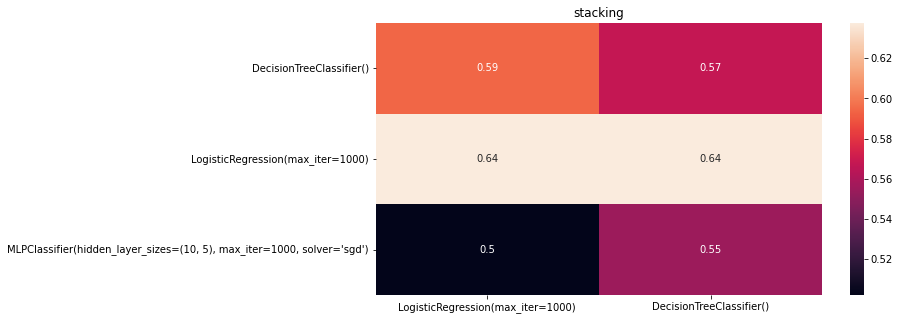

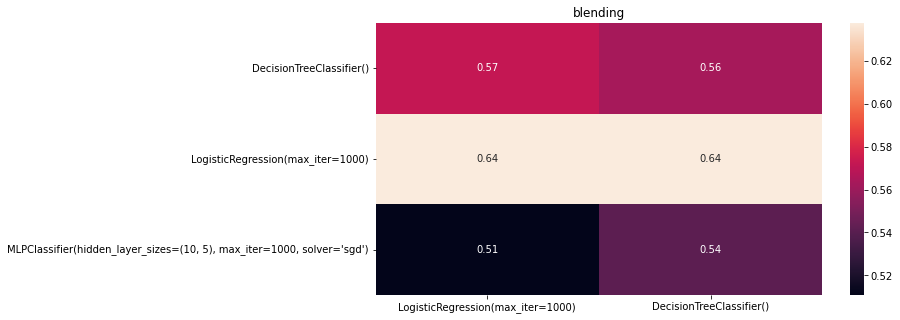

In [7]:
# plotting the heatmaps for methodologies

for i in range(len(methodology)):
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracy_matrix[i], annot=True, xticklabels=level1estimator, yticklabels=level0estimators)
    plt.title(methodology[i])
    plt.show()



In [8]:
# finding the best ensemble for each model (methodology = stacking)

best_ensemble_params = []
time_best = []
for i in range(len(level0estimators)):
    b= []
    t= []
    for j in range(len(level1estimator)):
        if accuracy_matrix[0][i][j] == np.max(accuracy_matrix[0][i]):
            b.append((level0estimators[i], level1estimator[j]))
            t.append(training_time_matrix[0][i][j])
            break
    best_ensemble_params.append(b)
    time_best.append(t)

# for normal_models
acc_normal = []
t_normal = []
for i in range(len(level0estimators)):
    t_Start = time.time()
    level0estimators[i].fit(X_train, y_train)
    y_normal_pred = level0estimators[i].predict(X_test)
    t_End = time.time()
    acc_normal.append(accuracy_score(y_test, y_normal_pred))
    t_normal.append(t_End - t_Start)
    


    

/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


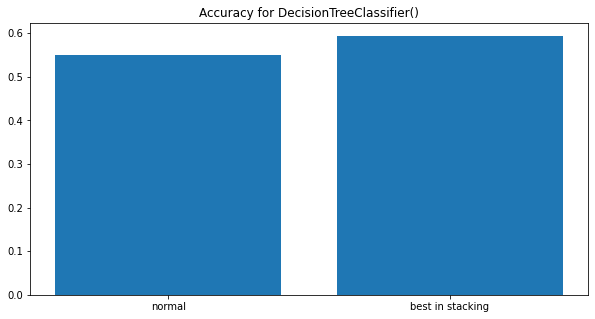

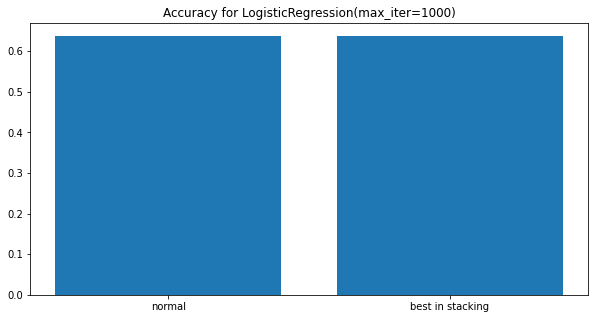

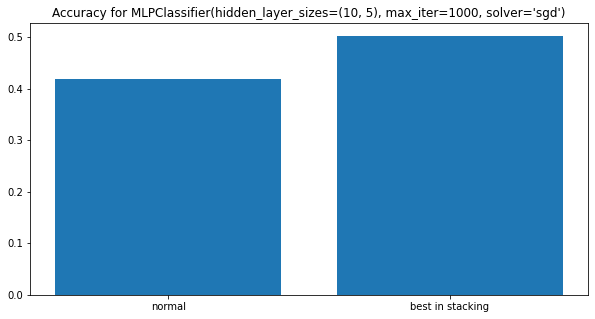

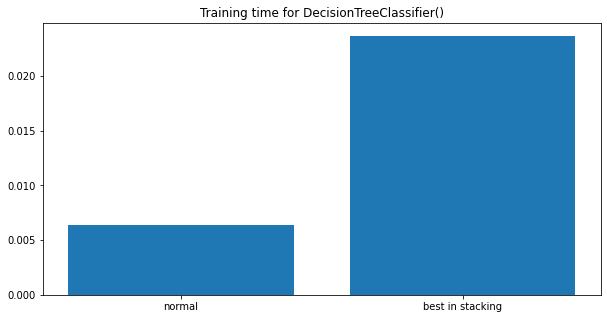

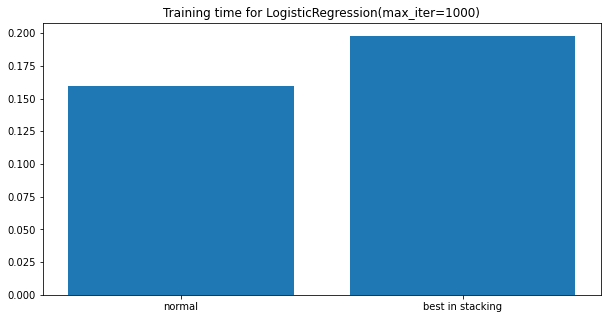

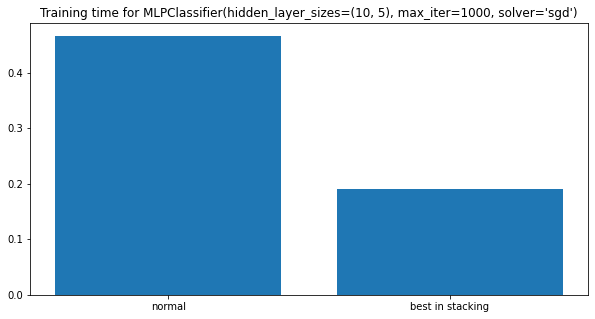

In [9]:
# printing histograms
for i in range(len(level0estimators)):
    plt.figure(figsize=(10, 5))
    plt.bar(['normal', 'best in stacking'], [acc_normal[i], accuracy_matrix[0][i][0]])
    plt.title('Accuracy for ' + str(level0estimators[i]))
    plt.show()

# printing time histograms
for i in range(len(level0estimators)):
    plt.figure(figsize=(10, 5))
    plt.bar(['normal', 'best in stacking'], [t_normal[i], time_best[i][0]])
    plt.title('Training time for ' + str(level0estimators[i]))
    plt.show()

#### Stacking Regressor

In [10]:
# getting the dataset
boston_dataset = pd.read_csv('../Datasets/HousingData.csv')
boston_dataset = boston_dataset.dropna()

# normalising the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
boston_dataset = pd.DataFrame(scaler.fit_transform(boston_dataset), columns=boston_dataset.columns)
print(boston_dataset.head())

       CRIM    ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  0.000000  0.18  0.067815   0.0  0.309129  0.577505  0.641607  0.269203   
1  0.000236  0.00  0.242302   0.0  0.165975  0.547998  0.782698  0.348962   
2  0.000236  0.00  0.242302   0.0  0.165975  0.694386  0.599382  0.348962   
3  0.000293  0.00  0.063050   0.0  0.143154  0.658555  0.441813  0.448545   
4  0.000264  0.00  0.063050   0.0  0.143154  0.549722  0.574665  0.448545   

        RAD       TAX   PTRATIO         B     LSTAT      MEDV  
0  0.000000  0.208015  0.287234  1.000000  0.089680  0.422222  
1  0.043478  0.104962  0.553191  1.000000  0.204470  0.368889  
2  0.043478  0.104962  0.553191  0.989678  0.063466  0.660000  
3  0.086957  0.066794  0.648936  0.994243  0.033389  0.631111  
4  0.086957  0.066794  0.648936  0.992950  0.096026  0.526667  


In [11]:
X = boston_dataset.drop('MEDV', axis=1)
y = boston_dataset['MEDV']

In [12]:
# defining the regression function of stacking

from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


def stacking_reg(level0estimators, level1estimator, methodology):
    num_estimators_l0 = len(level0estimators)

    models = []
    for i in range(num_estimators_l0):
        model = level0estimators[i]
        model.fit(X_train, y_train)
        models.append(model)

    if methodology == 'blending':
        predictions = []
        for i in range(num_estimators_l0):
            predictions.append(models[i].predict(X_test))
        predictions = np.array(predictions)
        predictions = np.mean(predictions, axis=0)
        return predictions
    
    elif methodology == 'stacking':
        validations = []
        predictions = []

        for i in range(num_estimators_l0):
            validations.append(models[i].predict(X_val))
            predictions.append(models[i].predict(X_test))

        validations = np.array(validations)
        validations = np.transpose(validations)

        # finding predictions on test set from level 0 estimators
        predictions = np.array(predictions)
        predictions = np.transpose(predictions)

        # training the level 1 estimator on validation set
        level1estimator.fit(validations, y_val)


        # finding final predictions from level 1 estimator
        final_predictions = level1estimator.predict(predictions)
        return final_predictions

In [13]:
# running on normal model
y_pred = stacking_reg([dtr], lr, 'stacking')
print(mean_squared_error(y_test, y_pred))

0.017916527468764074


In [14]:
import time
methodology = ['stacking', 'blending']
level0estimators = [dtr, lr, mlpr]
level1estimator = [lr, dtr]

mse_matrix = np.zeros((len(methodology), len(level0estimators), len(level1estimator)))
training_time_matrix = np.zeros((len(methodology), len(level0estimators), len(level1estimator)))

for i in range(len(methodology)):
    for j in range(len(level0estimators)):
        for k in range(len(level1estimator)):
            t_Start = time.time()
            y_pred = stacking_reg([level0estimators[j]], level1estimator[k], methodology[i])
            t_End = time.time()
            mse_matrix[i][j][k] = mean_squared_error(y_test, y_pred)
            training_time_matrix[i][j][k] = t_End - t_Start

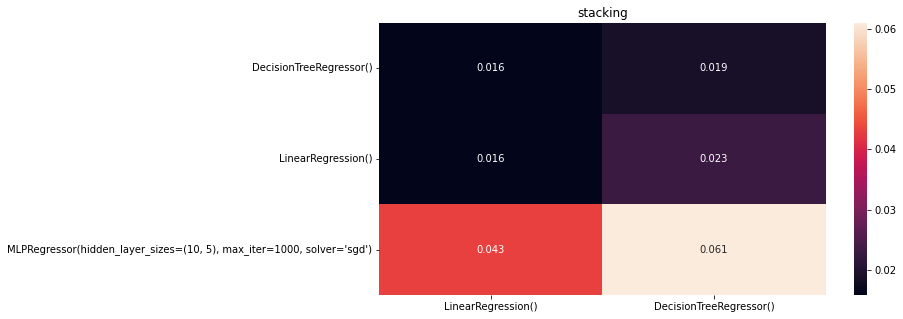

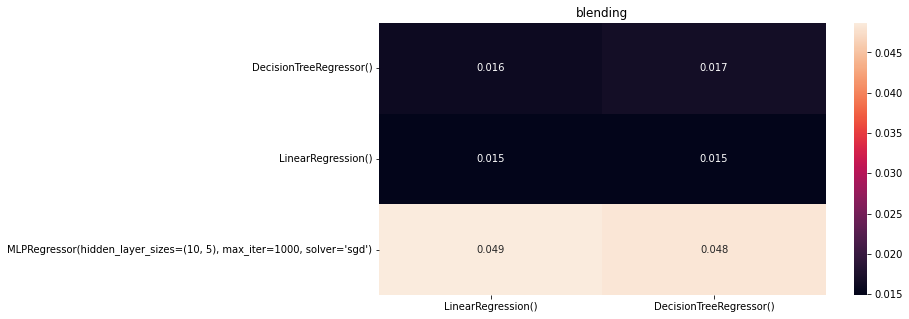

In [15]:
# plotting the heatmaps for methodologies

for i in range(len(methodology)):
    plt.figure(figsize=(10, 5))
    sns.heatmap(mse_matrix[i], annot=True, xticklabels=level1estimator, yticklabels=level0estimators)
    plt.title(methodology[i])
    plt.show()

In [16]:
# finding the best ensemble for each model (methodology = stacking)

best_ensemble_params = []
time_best = []
for i in range(len(level0estimators)):
    b= []
    t= []
    for j in range(len(level1estimator)):
        if mse_matrix[0][i][j] == np.min(mse_matrix[0][i]):
            b.append((level0estimators[i], level1estimator[j]))
            t.append(training_time_matrix[0][i][j])
            break
    best_ensemble_params.append(b)
    time_best.append(t)

# for normal_models
mse_normal = []
t_normal = []
for i in range(len(level0estimators)):
    t_Start = time.time()
    level0estimators[i].fit(X_train, y_train)
    y_normal_pred = level0estimators[i].predict(X_test)
    t_End = time.time()
    mse_normal.append(mean_squared_error(y_test, y_normal_pred))
    t_normal.append(t_End - t_Start)
    

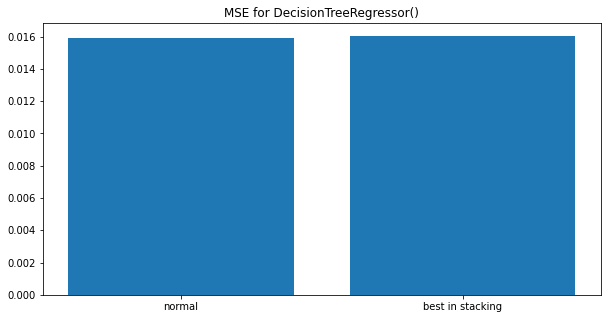

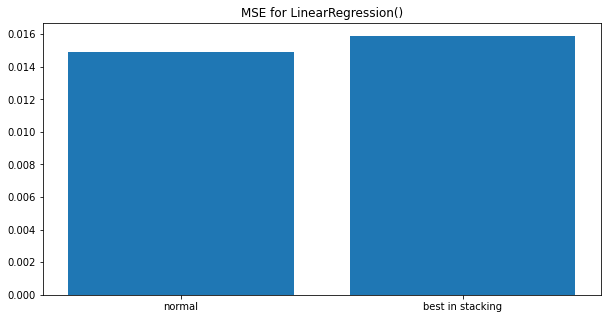

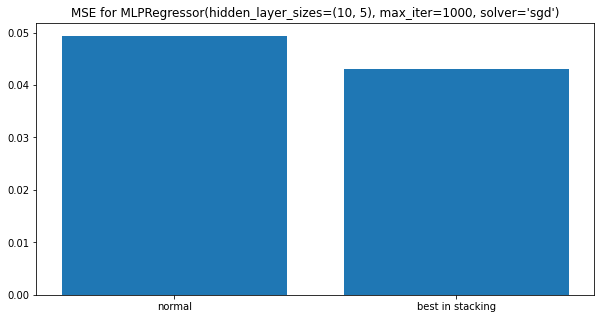

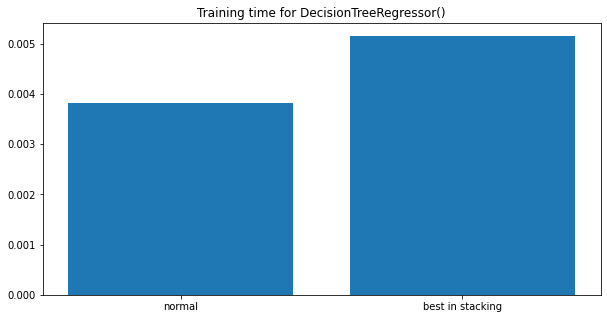

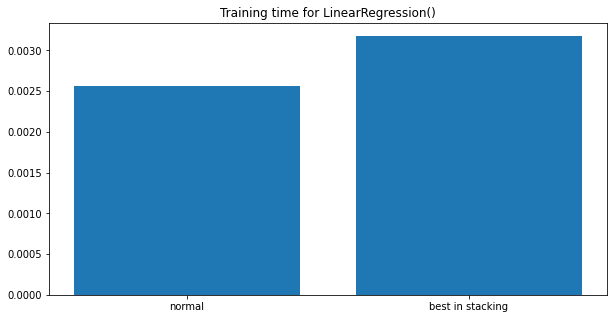

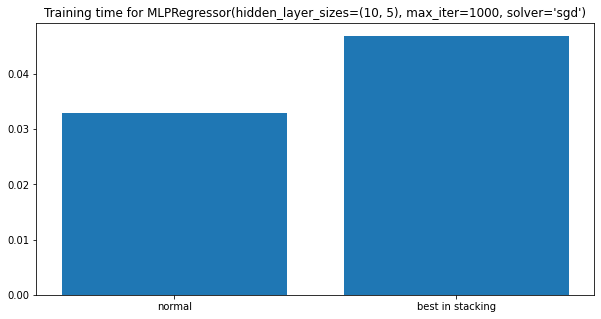

In [17]:
# printing histograms
for i in range(len(level0estimators)):
    plt.figure(figsize=(10, 5))
    plt.bar(['normal', 'best in stacking'], [mse_normal[i], mse_matrix[0][i][0]])
    plt.title('MSE for ' + str(level0estimators[i]))
    plt.show()

# printing time histograms
for i in range(len(level0estimators)):
    plt.figure(figsize=(10, 5))
    plt.bar(['normal', 'best in stacking'], [t_normal[i], time_best[i][0]])
    plt.title('Training time for ' + str(level0estimators[i]))
    plt.show()

### Results:

Training time increases in stacking because of multiple models.
MSE is nearly same or decreases in stacking.